<function matplotlib.pyplot.show(close=None, block=None)>

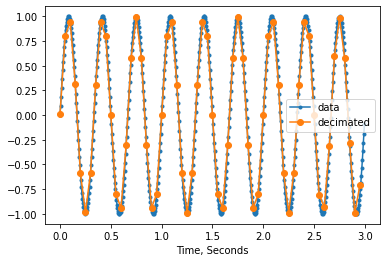

In [13]:
import numpy as np
import scipy as sc
from scipy import signal
import matplotlib.pyplot as plt
import rheosys as rhs



#sampling time settings
wave_duration = 3
sample_rate = 200
freq = 3
q_factor = 10
samples = wave_duration*sample_rate
samples_decimated = int(samples/q_factor)

#Frequency input selection from rheosys
x_exact = np.linspace(0, wave_duration, samples, endpoint=False)
y_exact = np.sin(x_exact*np.pi*freq*2)


#Sampling frequency to time vector use of scipy DECIMATE
x_vect_time = np.linspace(0, wave_duration, samples_decimated, endpoint=False)
y_vect_time = signal.decimate(y_exact,q_factor,)


#Figure plot of the corresponding fr
plt.plot(x_exact, y_exact, '.-', x_vect_time, y_vect_time, 'o-')
plt.xlabel('Time, Seconds')
plt.legend(['data', 'decimated'], loc='best')
plt.show


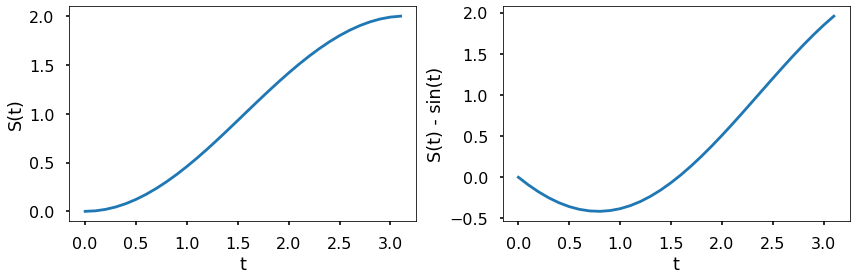

In [65]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
import rheosys as rhs

plt.style.use('seaborn-poster')


F = lambda t, s: np.sin(t)

t_eval = np.arange(0, np.pi, 0.1)
sol = solve_ivp(F, [0, np.pi], [0], t_eval=t_eval)

plt.figure(figsize = (12, 4))
plt.subplot(121)
plt.plot(sol.t, sol.y[0])
plt.xlabel('t')
plt.ylabel('S(t)')
plt.subplot(122)
plt.plot(sol.t, sol.y[0] - np.sin(sol.t))
plt.xlabel('t')
plt.ylabel('S(t) - sin(t)')
plt.tight_layout()
plt.show()

In [ ]:
class excitation():
    #Excitation signals used as input for the analysis,
    #   input must be defined as one value with the unit of ...
    #   output is defined with the unit of ...

    def sin (self):
        ouput=np.sin(x)
        return ouput

    def cos (self):
        ouput=np.sin(x)
        return ouput

class ode():
    #ODE included in rheological models that include mass-spring damper systems to describe the material properties
    #input variables needed for these solvers ... with units ...
    #output variables given from these solvers ... with units ...

    def maxwell():

    def kelvin():



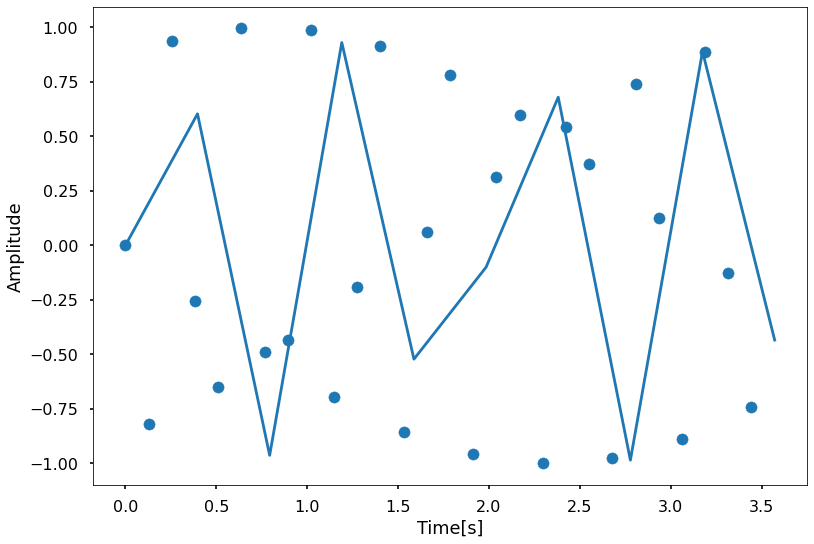

In [80]:
import matplotlib.pylab as plt
import numpy as np



f0=60                                       # f0 = excitation wave frequency [Hz]

N=100                                        # N = number of samples
Fs=28                                       # Fs = sampling frequency [Hz]

dt = 1/Fs                                   # Sampling period [s]
T = N*dt                                    # Record window duration [s]
t = np.linspace(0,T,Fs,endpoint=False)   # Time vector for sampling [s]

# generate samples at the specified times
y = np.sin(2*np.pi*f0*t); # [signal units]
t2=np.linspace(0,T,10)

plt.plot(t2,np.sin(2*np.pi*t2))
plt.scatter(t, y)
plt.xlabel('Time[s]')
plt.ylabel('Amplitude')
plt.axis('tight')
plt.show()

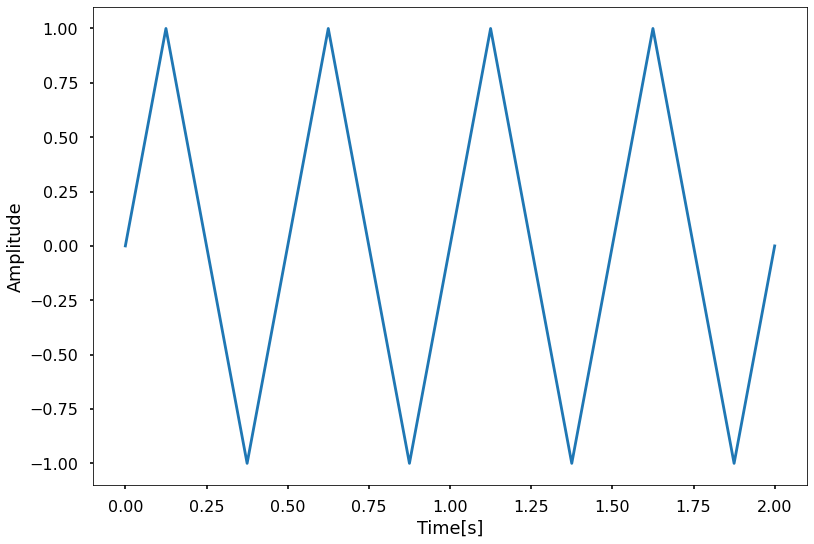

In [139]:
import numpy as np


def u_continuous(time):
    u=np.sin(time)
    return u

u_continuous(2*np.pi)

def u_sampling (excitation_frequency,sample_frequency,sample_time):
    f0=excitation_frequency                     # f0 = excitation wave frequency [Hz]
    Fs=sample_frequency                         # Fs = sampling frequency [Hz]
    T=sample_time                               # Record window duration [s]

    dt = 1/Fs                                   # Sampling period [s]
    t = np.arange(0,T+dt,dt)   # Time vector for sampling [s]

    # generate samples at the specified times
    u_sampled = np.sin(2*np.pi*f0*t); # [signal units]

    return (t,u_sampled)

#run the function
u,time= u_sampling(10,8,2)

plt.plot(u,time)
plt.xlabel('Time[s]')
plt.ylabel('Amplitude')
plt.axis('tight')
plt.show()



In [131]:
print(np.linspace(0,26,6))
print(np.arange(0,26,6))

[ 0.   5.2 10.4 15.6 20.8 26. ]
[ 0  6 12 18 24]


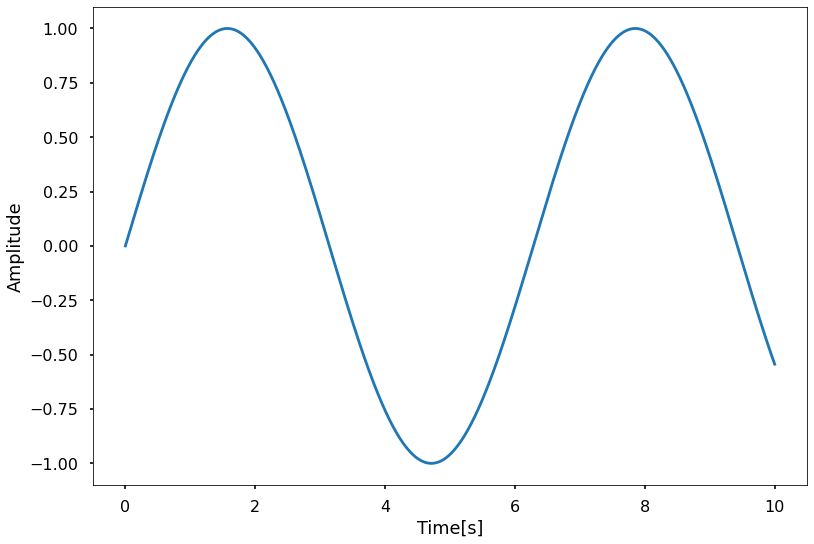

In [153]:
import numpy as np


def u_continuous(time):
    u=np.sin(time)
    return u


def u_sampling (excitation_frequency,sample_frequency,sample_time):
    f0=excitation_frequency                     # f0 = excitation wave frequency [Hz]
    Fs=sample_frequency                         # Fs = sampling frequency [Hz]
    T=sample_time                               # Record window duration [s]

    dt = 1/Fs                                   # Sampling period [s]
    t = np.arange(0,T+dt,dt)   # Time vector for sampling [s]

    # generate samples at the specified times
    u_sampled = np.sin(2*np.pi*f0*t); # [signal units]

    return (t,u_sampled)

#run the function
u,time= u_sampling(10,8,2)
t_test=np.arange(0,10,0.0002)
u2=u_continuous(t_test)

plt.plot(u,time)
#plt.plot(t_test,u2)
plt.xlabel('Time[s]')
plt.ylabel('Amplitude')
plt.axis('tight')
plt.show()



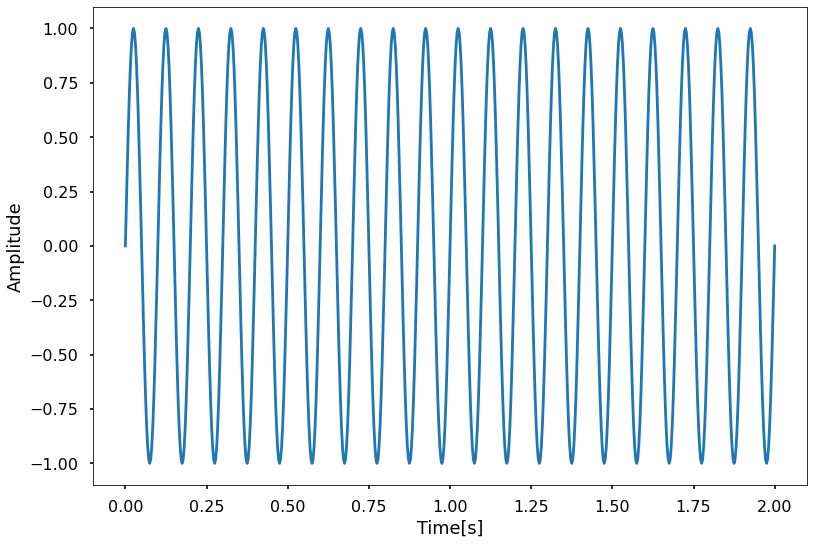

[3.041592653589793, 0.0]


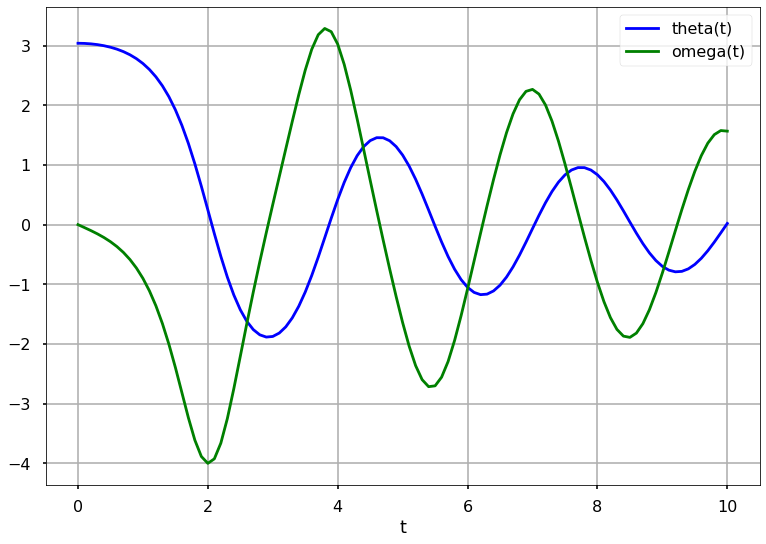

In [161]:
import numpy as np
import matplotlib.pyplot as plt

def u_continuous(time):
    u=np.sin(time)
    return u


def u_sampling (excitation_frequency,sample_frequency,sample_time):
    f0=excitation_frequency                     # f0 = excitation wave frequency [Hz]
    Fs=sample_frequency                         # Fs = sampling frequency [Hz]
    T=sample_time                               # Record window duration [s]

    dt = 1/Fs                                   # Sampling period [s]
    t = np.arange(0,T+dt,dt)   # Time vector for sampling [s]

    # generate samples at the specified times
    u_sampled = np.sin(2*np.pi*f0*t); # [signal units]

    return (t,u_sampled)

#run the function
u,time= u_sampling(10,320,2)
t_test=np.arange(0,10,0.0002)
u2=u_continuous(t_test)

plt.plot(u,time)
#plt.plot(t_test,u2)
plt.xlabel('Time[s]')
plt.ylabel('Amplitude')
plt.axis('tight')
plt.show()



def pend(y, t, b, c):
    theta, omega = y
    dydt = [omega, -b*omega - c*np.sin(theta)]
    return dydt

# Tau_dot=G*gamma_dot(t)- Tau*1/lambda
# Tau_dot=G*gamma_dot(t)- c*Tau

def viscosity(y,t,G,c)
    dydt=


b = 0.25
c = 5.0

y0 = [np.pi - 0.1, 0.0]
t = time


from scipy.integrate import odeint
sol = odeint(pend, y0, t, args=(b, c))

import matplotlib.pyplot as plt
plt.plot(t, sol[:, 0], 'b', label='theta(t)')
plt.plot(t, sol[:, 1], 'g', label='omega(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def viscosity(y, t, b, c):
    theta, omega = y
    dydt = [omega, -b*omega - c*np.sin(theta)]
    return dydt

b = 0.25
c = 5.0

y0 = [np.pi - 0.1, 0.0]
t = np.linspace(0, 10, 101)

from scipy.integrate import odeint
sol = odeint(viscosity, y0, t, args=(b, c))

import matplotlib.pyplot as plt
plt.plot(t, sol[:, 0], 'b', label='theta(t)')
plt.plot(t, sol[:, 1], 'g', label='omega(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()